# Model building

In [1]:
# importing libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from joblib import dump
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

sys.path.append("../src/")
# from utils import model_eval, plot_learning_curve
from tools import model_eval, plot_learning_curve

# import user-defined functions
# from model_eval import model_eval
# from plot_learning_curve import plot_learning_curve

## Load train data

In [2]:
# load train data
train = pd.read_csv("../data/train.csv")

In [3]:
# removing player_id_cat
train = train.drop("player_id_cat", axis=1)

In [4]:
# dimensions
train.shape

(6808, 16)

## Separating features from the target variable

In [5]:
# matrix of features
X = train.drop("churn", axis=1)

# target variable vector
y = train["churn"]

In [6]:
# dimensions
X.shape, y.shape

((6808, 15), (6808,))

## Splitting the dataset into training and test sets

In [7]:
# splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (5446, 15)
Train target shape   :  (5446,)
Test features shape  :  (1362, 15)
Test target shape    :  (1362,)


In [8]:
# define a list of models and of model names
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    XGBClassifier(random_state=42, use_label_encoder=False, n_jobs=-1),
]

model_names = [
    "Logistic Regression",
    "k-Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
]

In [9]:
# train and evaluate models
acc = []
f1 = []
precision = []
recall = []

eval_acc = {}
eval_f1 = {}
eval_precision = {}
eval_recall = {}

for model in range(len(models)):
    classification_model = models[model]
    classification_model.fit(X_train, y_train)
    y_pred = classification_model.predict(X_test)

    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))

eval_acc = {"Modeling Algorithm": model_names, "Accuracy": acc}
eval_f1 = {"Modeling Algorithm": model_names, "F1 score": f1}
eval_precision = {"Modeling Algorithm": model_names, "Precision": precision}
eval_recall = {"Modeling Algorithm": model_names, "Recall": recall}

[00:23:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
# create a table containing the performance of each model
df_acc = pd.DataFrame(eval_acc)
df_f1 = pd.DataFrame(eval_f1)
df_precision = pd.DataFrame(eval_precision)
df_recall = pd.DataFrame(eval_recall)

score_table = pd.concat(
    [df_acc, df_f1["F1 score"], df_precision["Precision"], df_recall["Recall"]], axis=1
)
score_table.sort_values(by="F1 score", ascending=[False])

,Modeling Algorithm,Accuracy,F1 score,Precision,Recall
4,XGBoost,0.989721,0.993476,0.990706,0.996262
3,Random Forest,0.979442,0.987001,0.980627,0.993458
2,Decision Tree,0.972100,0.982260,0.981343,0.983178
1,k-Nearest Neighbors,0.769457,0.861062,0.817647,0.909346
0,Logistic Regression,0.755507,0.859316,0.784117,0.950467


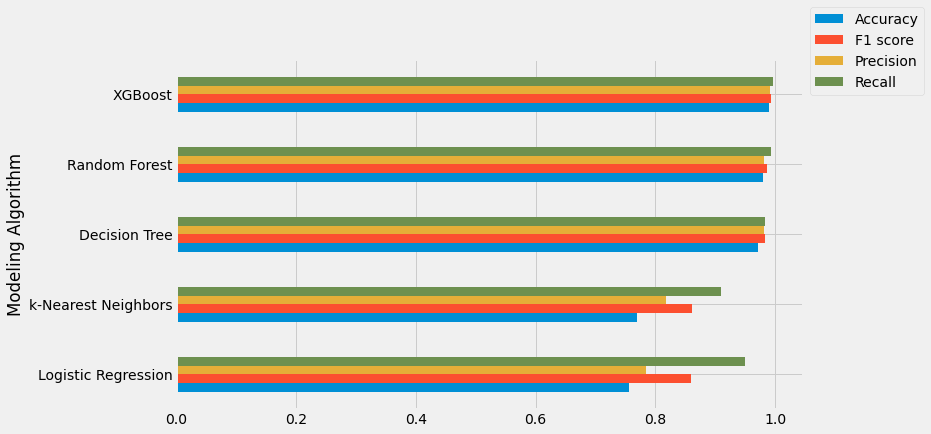

In [11]:
# plot model performances according to 4 traditional metrics
plt.style.use("fivethirtyeight")
ax = score_table.sort_values(by=["F1 score"]).plot(
    kind="barh", x="Modeling Algorithm", figsize=(10, 6), stacked=False
)
ax.legend(bbox_to_anchor=(1, 1.17))
plt.grid(which="minor", axis="x", color="k")
plt.show()
plt.close()

Using default parameters all of our models had apparently a pretty good performance, and as we can see from the previous plot, the best performances were obtained by:
* XGBoost
* Random Forest
* Decision Tree

Since we have an imbalanced dataset, accuracy is not the recommended metric to be used. In this case, it's better to use:
* precision (out of those which I classiﬁed as positives correctly predicted, how many are correct?) 
* recall (out of all positives, how many did I found?), 
* or F1 score (balances precision and recall in a single number). Suited for the imbalanced class problem, but less explainable.


|Metrics (T = true, F = false, P = positive, N = negative)                                      |
|:----------------------------------------------------------------------------------------------|
| \begin{align} Accuracy = \frac{TP+TN}{TP+TN+FN+FP} \end{align}                                |
| \begin{align} Recall = \frac{TP}{TP+FN} \end{align}                                           |
| \begin{align} Precision = \frac{TP}{TP+FP} \end{align}                                        |
| \begin{align} F1= \frac{2 \cdot Precision \cdot Recall}{Precision+Recall} \end{align}         |


From our three best performers, the Decision Tree brings more explainability to the problem and, so this will be our choice.

## Decision Tree

### Model with default parameters

In [12]:
# create a classifier
tree_model_default = DecisionTreeClassifier(random_state=42)
# train the model
tree_model_default.fit(X_train, y_train)
# predictions
y_pred = tree_model_default.predict(X_test)

#### Metrics

In [13]:
# model evaluation
model_eval(y_test, y_pred)

F1 score:  0.9823
Precision: 0.9813
Recall:    0.9832
Accuracy:  0.9721


#### Confusion matrix

Calculating the confusion matrix helps us to summarize the performance of our model. The convention used by scikit learn is given below.

|  Scikit learn convention   |
|:-----:|
|TN FP|
|FN TP|

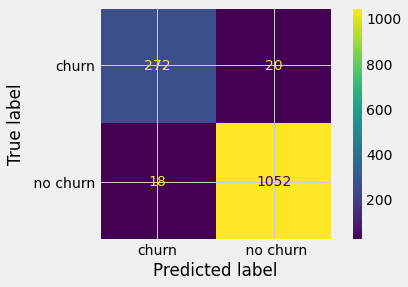

In [14]:
# define class names
class_names = ["churn", " no churn"]

# build the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# print(f"Confusion matrix:\n{confusion}")

# display the confusion matrix
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.show()
plt.close()

The above confusion matrix summarizes the correct and incorrect predictions made by our model. The amount of predicted false positives (top right) and false negatives (top left) are almost the same.

In [15]:
feature_names = [
    "deposit_approved_sum",
    "withdrawal_approved_sum",
    "turnover_cash_sum",
    "winning_cash_sum",
    "result_cash_sum",
    "NGR_sum",
    "bonus_cash_sum",
    "session_sum",
    "female",
    "male",
    "frequency",
    "recency",
    "T",
    "monetary_value",
    "purchase_next_4_weeks",
]

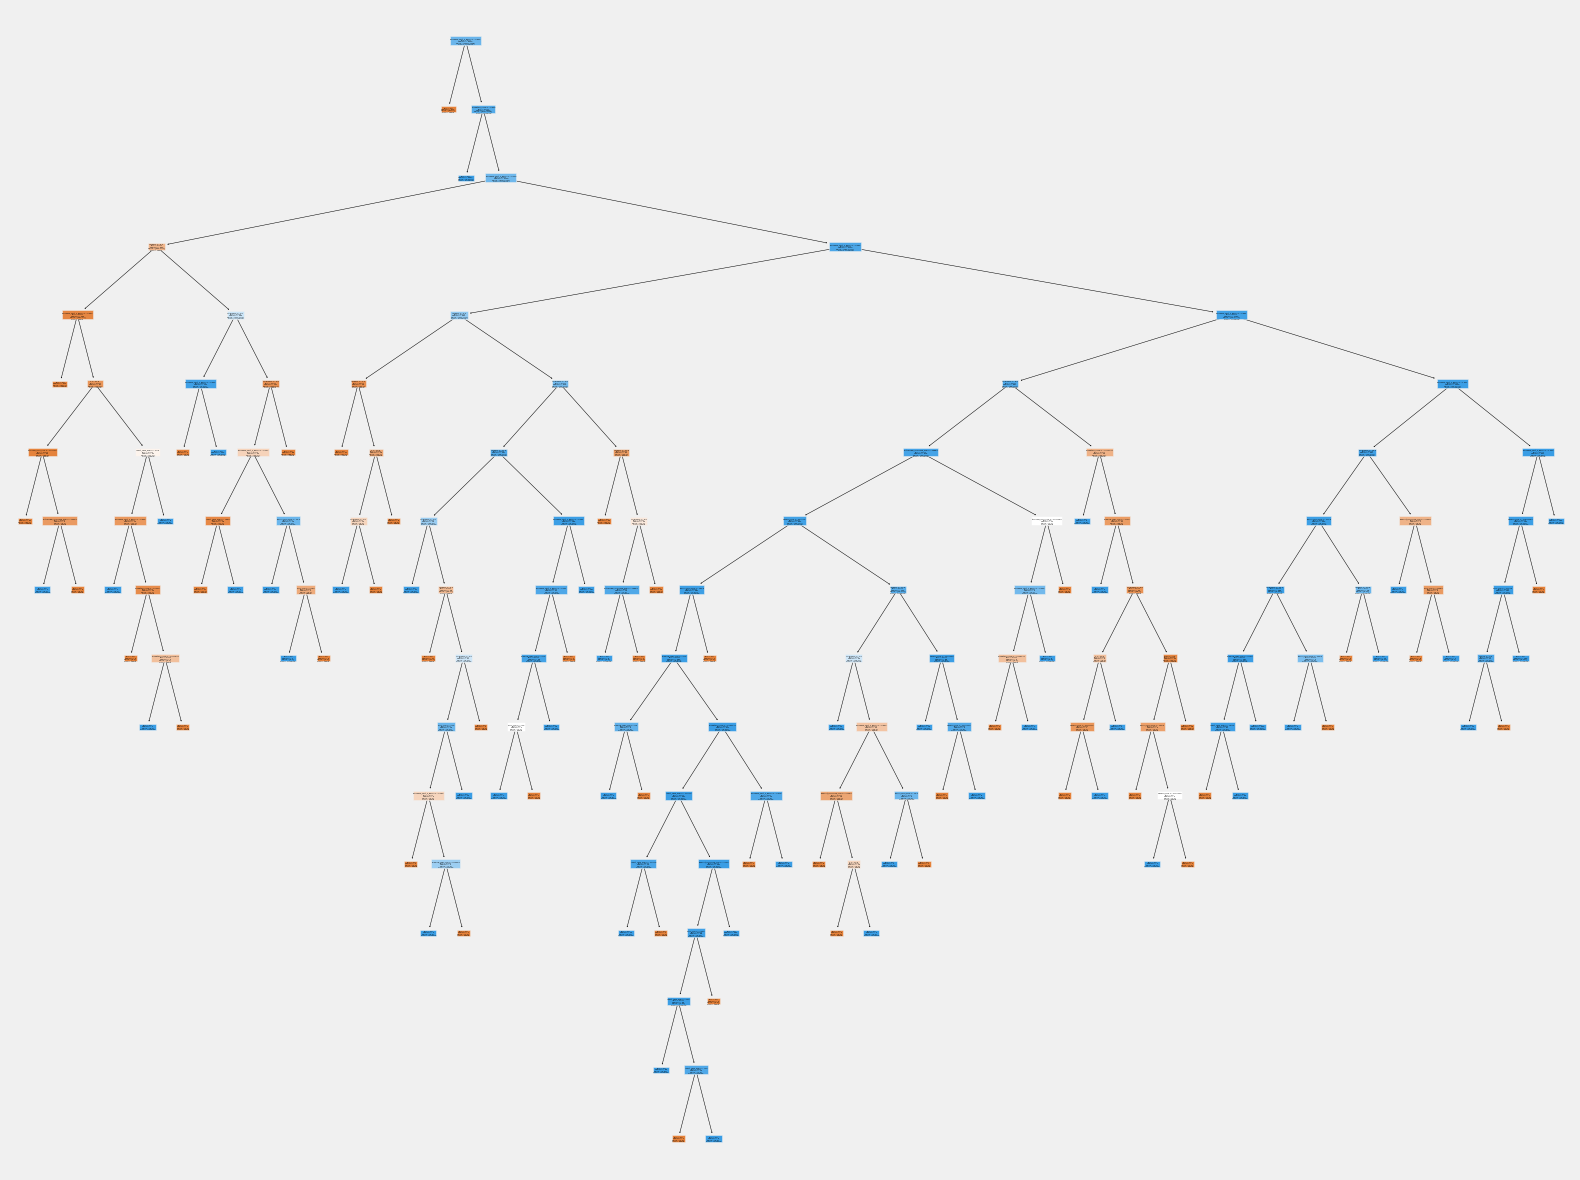

In [16]:
# visualize our tree
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(
    tree_model_default,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
)

Without choosing any parameters our tree was free to expand, and we can see from the above plot that this lead to a certain complexity of our model. We can try to reduce this by setting the parameter `max_depth`,  the maximum depth of the tree.

#### Save the model

In [17]:
# save the model
dump(tree_model_default, "../models/model_tree_model_default.joblib")

['../models/model_tree_model_default.joblib']

### Model with `max_depth=5`

In [18]:
# create a classifier
tree_model_md5 = DecisionTreeClassifier(max_depth=5, random_state=42)
# train the model
tree_model_md5.fit(X_train, y_train)
# predictions
y_pred = tree_model_md5.predict(X_test)

#### Metrics

In [19]:
# model evaluation
model_eval(y_test, y_pred)

F1 score:  0.9747
Precision: 0.9593
Recall:    0.9907
Accuracy:  0.9596


#### Confusion matrix

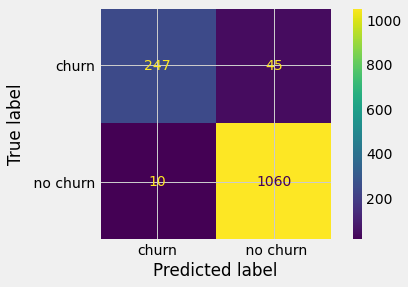

In [20]:
# define class names
class_names = ["churn", " no churn"]

# build the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# print(f"Confusion matrix:\n{confusion}")

# display the confusion matrix
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.show()
plt.close()

Fixing the `max_depth` parameter our model had a slight descrease in performance, but continues performing pretty good. Now it increased the prediction of false positive and decrease the prediction of false negative.

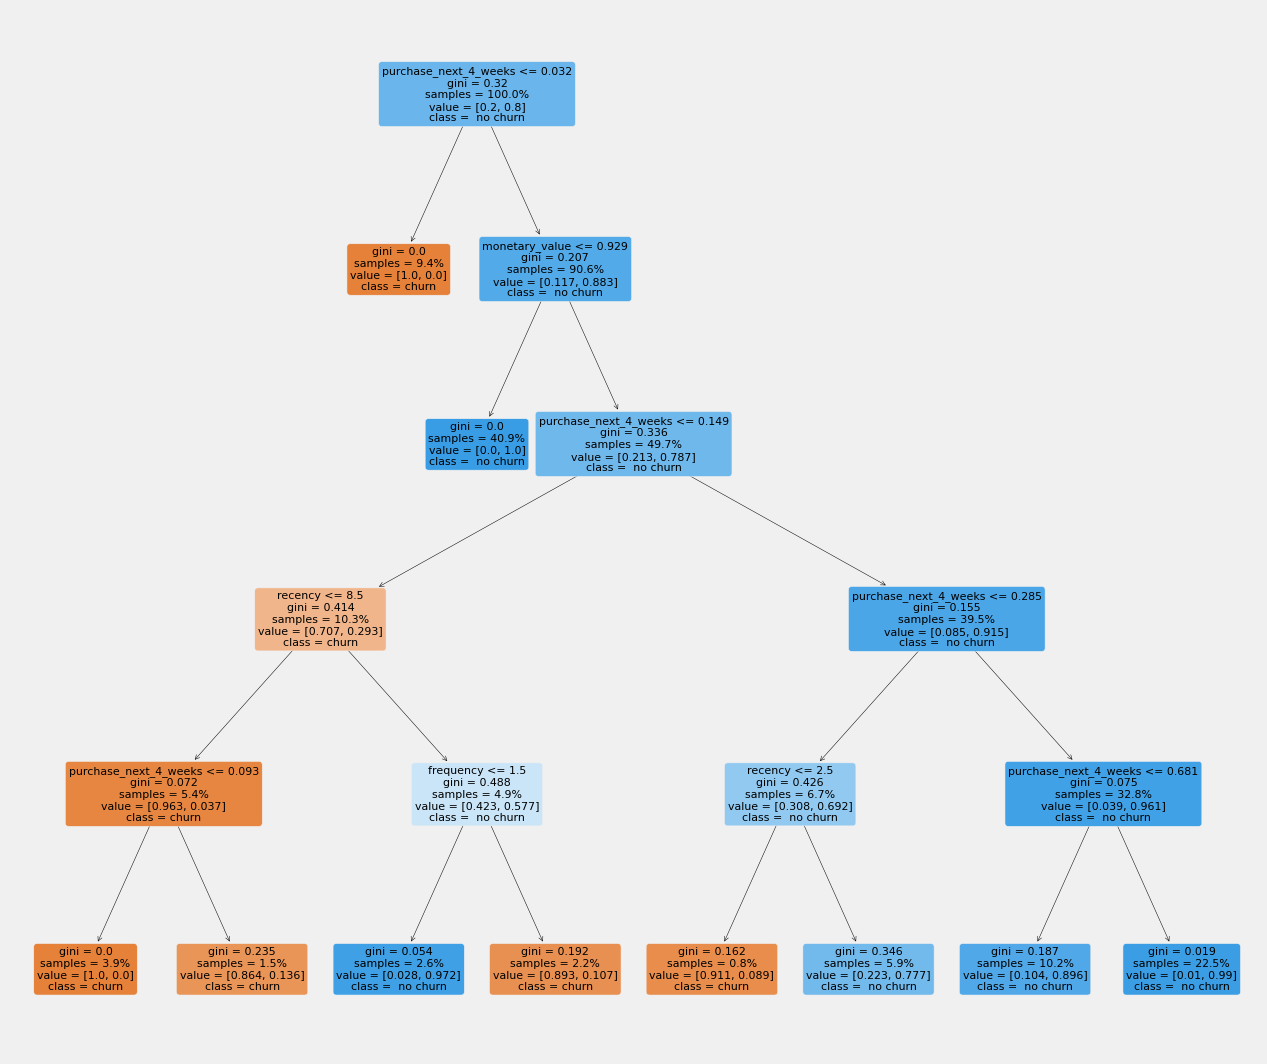

In [21]:
# visualize our tree
fig = plt.figure(figsize=(20, 18))
_ = tree.plot_tree(
    tree_model_md5,
    feature_names=feature_names,
    class_names=class_names,
    proportion=True,
    filled=True,
    rounded=True,
    fontsize=11,
)

Reducing the `max_depth` reduced the complexity of the model while increasing its explainability without compromising its F1 score or precision for example.

In [22]:
# metrics.SCORERS.keys()

#### Learning curve

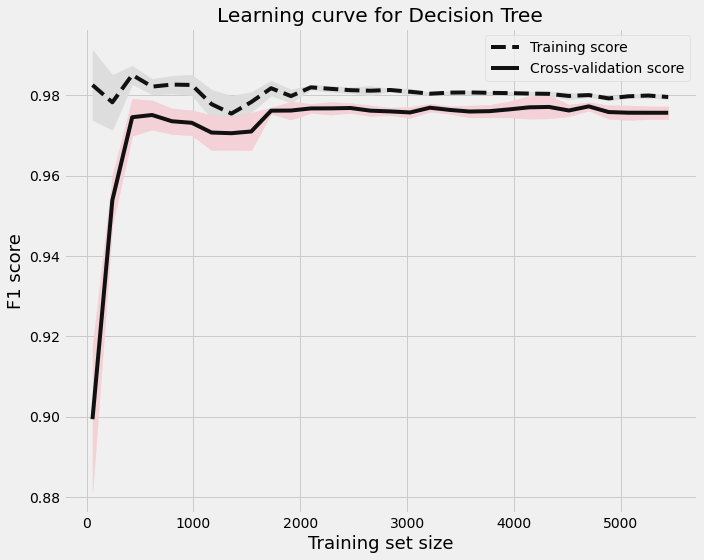

In [23]:
plt.figure(figsize=(10, 8))
plot_learning_curve(X, y, 5, plt)

#### Save the model

In [24]:
# save the model
dump(tree_model_md5, "../models/model_tree_md5.joblib")

['../models/model_tree_md5.joblib']